In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import ndimage
from scipy import signal
import os
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import PyPDF2
import io
import cmocean

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [2]:
magicc_scm = pd.read_csv('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/magicc7/rcmip_phase-1_magicc7.1.0.beta_v1-0-0.csv').set_index(['Region','Scenario','Variable'])
magicc_scm.iloc[:,3:] = magicc_scm.iloc[:,3:].apply(pd.to_numeric)
magicc_scm.columns = list(magicc_scm.columns)[:3] + [int(x) for x in list(magicc_scm.columns)[3:]]

In [4]:
# fair_scm = pd.concat([pd.read_csv(x) for x in glob.glob('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/fair/*default*v1-0-1*')])
# fair_scm.columns = [str(x) for x in np.arange(1850,2501)]+list(fair_scm.columns[-6:])
# fair_scm = fair_scm.loc[:,list(fair_scm.columns[-6:])+[str(x) for x in np.arange(1850,2501)]]
# fair_scm.iloc[:,6:] = fair_scm.iloc[:,6:].apply(pd.to_numeric)
# fair_scm.columns = list(fair_scm.columns)[:6] + [int(x) for x in list(fair_scm.columns)[6:]]
# fair_scm = fair_scm.set_index(['Region','Scenario','Variable'])

In [5]:
## import RCMIP dataset
from tools.RCMIP import *

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/home/leachl/Documents/Simple_models/FaIR_v2-0/GIR/tools/RCMIP.py:60: PerformanceWarning: indexing past lexsort depth may impact performance.
  GIR_to_RCMIP_map.loc[RCMIP_to_GIR_map_concs.values(),'RCMIP_concs_unit'] = RCMIP_concs.loc[('World','ssp245')].reindex(RCMIP_to_GIR_map_concs.keys()).loc[:,'Unit'].values#.loc[('World','ssp245',RCMIP_to_GIR_map_concs.keys()),'Unit'].values


In [ ]:
RCMIP_emms.index.levels[1]

In [ ]:
scenarios = ['ssp119','ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip','ssp370-lowNTCF-gidden', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
RCMIP_ssp_emms=pd.concat([RCMIP_to_GIR_input_emms(x).dropna(axis=1,how='all').interpolate() for x in scenarios],axis=1,keys=scenarios)
RCMIP_ssp_forc=pd.concat([get_RCMIP_forc(x).interpolate() for x in scenarios],axis=1,keys=scenarios)

In [ ]:
RCMIP_thermal_params = tcr_ecs_to_q(pd.DataFrame([[4.1,239],[1.75,3]],index=['d','TCR_ECS'],columns=pd.MultiIndex.from_product([['default'],[1,2]])),F_2x=3.76)

In [8]:
GIR_gas_params = pd.concat([pd.read_csv('./Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)],axis=1,keys=['default'])

In [ ]:
GIR_ssps = run_GIR(emissions_in=RCMIP_ssp_emms.reindex(GIR_gas_params.columns.levels[-1],axis=1,level=-1),forcing_in=RCMIP_ssp_forc,\
                  gas_parameters=GIR_gas_params,thermal_parameters=RCMIP_thermal_params)

In [ ]:
GIR_ssps['C'].xs('carbon_dioxide',axis=1,level=-1).plot()

### tune thermal params

In [ ]:
magicc_abrupt_forc = magicc_scm.loc[('World','1pctCO2-4xext','Effective Radiative Forcing')].iloc[3:]
magicc_abrupt_temp = magicc_scm.loc[('World','1pctCO2-4xext','Surface Air Temperature Change')].iloc[3:]

In [ ]:
## tune the forcing -> temp relation to MAGICC:
def run_GIR_exp(x):
    thermal_params = pd.DataFrame(x.reshape(2,3),index=['d','q'],columns=pd.MultiIndex.from_product([['default'],[1,2,3]]))
    T_out = run_GIR(emissions_in=return_empty_emissions(pd.DataFrame(magicc_abrupt_forc).droplevel(0,axis=1)),forcing_in=pd.DataFrame(magicc_abrupt_forc).droplevel(0,axis=1).apply(pd.to_numeric),thermal_parameters=thermal_params,show_run_info=False)['T']
    return T_out.values.flatten()

In [6]:
# sp.optimize.minimize(lambda x:np.sum((run_GIR_exp(x)-magicc_abrupt_temp.values.flatten())**2),x0=np.array([1,10,100,0.3,0.4,0.3]),method='nelder-mead',options={'maxiter': 2500, 'maxfev': 2500})

## best fit params:
magicc_thermal_params = pd.DataFrame(np.array([2.93052308e+00, 1.98305034e+01, 2.41058800e+02, 3.43736672e-01,2.20500956e-01, 1.23545583e-01]).reshape(2,3),index=['d','q'],columns=pd.MultiIndex.from_product([['GIR_MAGICC'],[1,2,3]]))

### tune f parameters

In [ ]:
forc_1pct = magicc_scm.loc[('World','1pctCO2','Effective Radiative Forcing')].iloc[3:].values.astype(float)[:210]
conc_1pct = magicc_scm.loc[('World','1pctCO2','Atmospheric Concentrations|CO2')].iloc[3:].values.astype(float)[:210]

In [ ]:
magicc_f_params = sp.optimize.minimize(lambda x:np.sum(((x[0]*np.log(conc_1pct/conc_1pct[0])+x[1]*(conc_1pct-conc_1pct[0])+x[2]*(np.sqrt(conc_1pct)-np.sqrt(conc_1pct[0])))-forc_1pct)**2),x0=[5,0.1,0.1],method='nelder-mead')

print('f=',magicc_f_params.x)
## NOTE: these parameters look a bit odd, but do a decent job of fitting to MAGICC over both history and high emission scenarios (<0.03Wm-2 error)

### tune carbon cycle parameters

In [ ]:
from pdfo import pdfo

In [ ]:
## start by tuning to esm-ssp370
emms_ssp370 = RCMIP_to_GIR_input_emms('ssp585')['carbon_dioxide'].interpolate()
conc_ssp370 = magicc_scm.loc[('World','esm-ssp585','Atmospheric Concentrations|CO2')].iloc[3:].astype(float)
temp_ssp370 = magicc_scm.loc[('World','esm-ssp585','Surface Air Temperature Change')].iloc[3:].astype(float)

In [ ]:
init_params = pd.concat([GIR_gas_params['default'][['carbon_dioxide']]],axis=1,keys=['default'])
init_params.loc['PI_conc']=284

In [ ]:
init_params = pd.concat([GIR_gas_params['default'][['carbon_dioxide']]],axis=1,keys=['default'])
init_params.loc['PI_conc']=284

def minimize_magicc_cc(x):
    run_params = init_params.copy()
    run_params.loc['r0'] = x[0]
    run_params.loc['rC'] = x[1]
    run_params.loc['rT'] = x[2]
    run = invert_concentrations_prescribed_T(pd.concat([pd.DataFrame(conc_ssp370.rename('carbon_dioxide'))],axis=1,keys=['default']),gas_parameters=run_params,T=temp_ssp370)['Emissions'][('default','carbon_dioxide')].rolling(2).mean()
    return np.sum((run - emms_ssp370)**2)

magicc_cc_params = pdfo(minimize_magicc_cc,[30,0.019,4.165],method='bobyqa')
print('magicc cc params:')
print('r0 = ',magicc_cc_params.x[0])
print('rC = ',magicc_cc_params.x[1])
print('rT = ',magicc_cc_params.x[2])

## Let's try comparing some (default) output

In [9]:
scenarios = ['ssp'+x for x in ['119','126','245','370','370-lowNTCF-aerchemmip','370-lowNTCF-gidden','434','460','534-over','585']]
ssp_emms = pd.concat([RCMIP_to_GIR_input_emms(x) for x in scenarios],keys=['esm-'+x+'-allGHG' for x in scenarios],axis=1).interpolate()
ssp_emms = ssp_emms.loc[1850:] - ssp_emms.loc[1750]
ssp_forc = pd.concat([get_RCMIP_forc(x) for x in scenarios],keys=['esm-'+x+'-allGHG' for x in scenarios],axis=1).interpolate().loc[1850:]

ssp_gas_list = [x for x in GIR_gas_params.columns.levels[-1] if '|' not in x]

In [10]:
# magicc_gir_gas_params = GIR_gas_params['default'].copy()
# magicc_gir_gas_params.loc[['r0','rC','rT'],'carbon_dioxide'] = [29.37,0.019,4.165]#[23.44,0.0249,5.458]
# magicc_gir_gas_params.loc['PI_conc','carbon_dioxide'] = 284
# magicc_gir_gas_params.loc[['f1','f2','f3'],'carbon_dioxide'] = [4.326861,-2e-06,0.134678]
# magicc_gir_gas_params = pd.concat([magicc_gir_gas_params],axis=1,keys=['MAGICC_GIR'])

ssp_run_gas_params = GIR_gas_params.copy()
ssp_run_gas_params.loc[['r0','rC','rT'],('default','carbon_dioxide')] = [29.37,0.019,4.165]

ssp_GIR_run = run_GIR(emissions_in=ssp_emms.reindex(ssp_gas_list,axis=1,level=1),forcing_in=ssp_forc,gas_parameters=ssp_run_gas_params,thermal_parameters=magicc_thermal_params)

# fig,ax = plt.subplots(figsize=(15,10))

# ssp_GIR_run['C'].xs('carbon_dioxide',axis=1,level=-1).plot(ax=ax,c='k',legend=None)

# magicc_scm.loc[('World',['esm-'+x+'-allGHG' for x in scenarios],'Atmospheric Concentrations|CO2'),:].iloc[:,3:].T.plot(ax=ax,c='r',legend=None,ls='--')

# plt.title('GIR vs MAGICC7 - CO$_2$ concentrations')

Integrating 10 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3', 'oc'], between 1850 and 2500...


100%|██████████| 650/650 [00:00<00:00, 2600.84 timestep/s]


In [11]:
## make function that converts GIR output into RCMIP output

concs_model = ssp_GIR_run['C'].columns.levels[1][ssp_GIR_run['C'].columns.codes[1]] +'-'+ ssp_GIR_run['C'].columns.levels[2][ssp_GIR_run['C'].columns.codes[2]]
concs_scenario = ssp_GIR_run['C'].columns.levels[0][ssp_GIR_run['C'].columns.codes[0]]

concs_RCMIP_out = ssp_GIR_run['C'].T.apply(lambda x: x/GIR_to_RCMIP_map.loc[x.name[-1],'RCMIP_concs_scaling'],axis=1).reset_index()
#add RCMIP var name
concs_RCMIP_out['Variable'] = GIR_to_RCMIP_map.loc[concs_RCMIP_out['Gas name'],'RCMIP_concs_key'].values
# add model designation
concs_RCMIP_out['Model'] = 'unspecified'
concs_RCMIP_out['Climatemodel'] = 'gas:'+concs_RCMIP_out['Gas cycle set'] + ' | thermal:'+concs_RCMIP_out['Thermal set']
concs_RCMIP_out['Region'] = 'World'
concs_RCMIP_out['Unit'] = GIR_to_RCMIP_map.loc[concs_RCMIP_out['Gas name'],'RCMIP_concs_unit'].values
concs_RCMIP_out = concs_RCMIP_out.set_index(['Region','Scenario','Variable','Model','Unit','Climatemodel']).iloc[:,3:].dropna(how='all')

In [12]:
forc_model = ssp_GIR_run['RF'].columns.levels[1][ssp_GIR_run['RF'].columns.codes[1]] +'-'+ ssp_GIR_run['RF'].columns.levels[2][ssp_GIR_run['RF'].columns.codes[2]]
forc_scenario = ssp_GIR_run['RF'].columns.levels[0][ssp_GIR_run['RF'].columns.codes[0]]

forc_RCMIP_out = ssp_GIR_run['RF'].T.reset_index()#.apply(lambda x: x/GIR_to_RCMIP_map.loc[x.name[-1],'RCMIP_concs_scaling'],axis=1).reset_index()
all_forcings = forc_RCMIP_out['Forcing component'].unique()

direct_forc = [x for x in all_forcings if '|' not in x]
indirect_forc = list(set([x for x in all_forcings if '|' in x]))

direct_forc_out = forc_RCMIP_out.loc[forc_RCMIP_out['Forcing component'].isin(direct_forc)]
direct_forc_out['Variable'] = GIR_to_RCMIP_map_forc.loc[direct_forc_out['Forcing component']].values
indirect_forc_out = forc_RCMIP_out.loc[forc_RCMIP_out['Forcing component'].isin(indirect_forc)]
indirect_forc_out['Forcing component'] = indirect_forc_out['Forcing component'].str.split('|',expand=True)[1]
indirect_forc_out = indirect_forc_out.groupby(['Scenario','Gas cycle set','Thermal set','Forcing component']).sum().reset_index()
indirect_forc_out['Variable'] = GIR_to_RCMIP_map_forc.loc[indirect_forc_out['Forcing component']].values

all_forc_out = pd.concat([direct_forc_out,indirect_forc_out])
all_forc_out['Region']='World'
all_forc_out['Model']='unspecified'
all_forc_out['Unit']='W / m^2'
all_forc_out['Climatemodel'] = 'gas:'+all_forc_out['Gas cycle set'] + ' | thermal:'+all_forc_out['Thermal set']
all_forc_out = all_forc_out.set_index(['Region','Scenario','Variable','Model','Unit','Climatemodel']).iloc[:,3:]

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


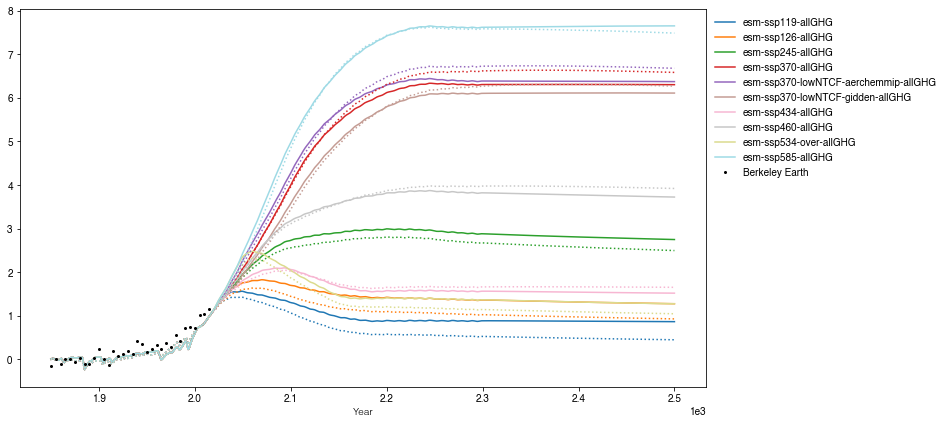

In [13]:
BE_GMST = pd.read_csv('http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_summary.txt',skiprows=48,index_col=0,usecols=[0,1],names=['Year','GMST'],delim_whitespace=True)
b, a = sp.signal.butter(2, 0.1)
BE_GMST['smooth'] = sp.signal.filtfilt(b, a, BE_GMST.values.flatten())

scenario_list = all_forc_out.index.levels[1]

colors = dict(zip(scenario_list,matplotlib.cm.tab20(np.linspace(0,1,scenario_list.size))))

fig,ax = plt.subplots(figsize=(10,6))

[ax.plot(ssp_GIR_run['T'][scen],label=scen,color=colors[scen]) for scen in scenario_list]
[ax.plot(magicc_scm.loc[('World',scen,'Surface Air Temperature Change'),range(1850,2501)],color=colors[scen],ls=':') for scen in scenario_list]

(BE_GMST['GMST'].iloc[::5]-BE_GMST.loc[1850:1900,'GMST'].mean()).plot(marker='o',c='k',lw=0,ms=2,label='Berkeley Earth')
    
plt.tight_layout()
ax.legend(loc='upper left',bbox_to_anchor=(1,1))

# fig.savefig('./GIR_output/RCMIP/RCMIP_allGHG_TEMP.pdf',bbox_inches='tight',dpi=600)

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.


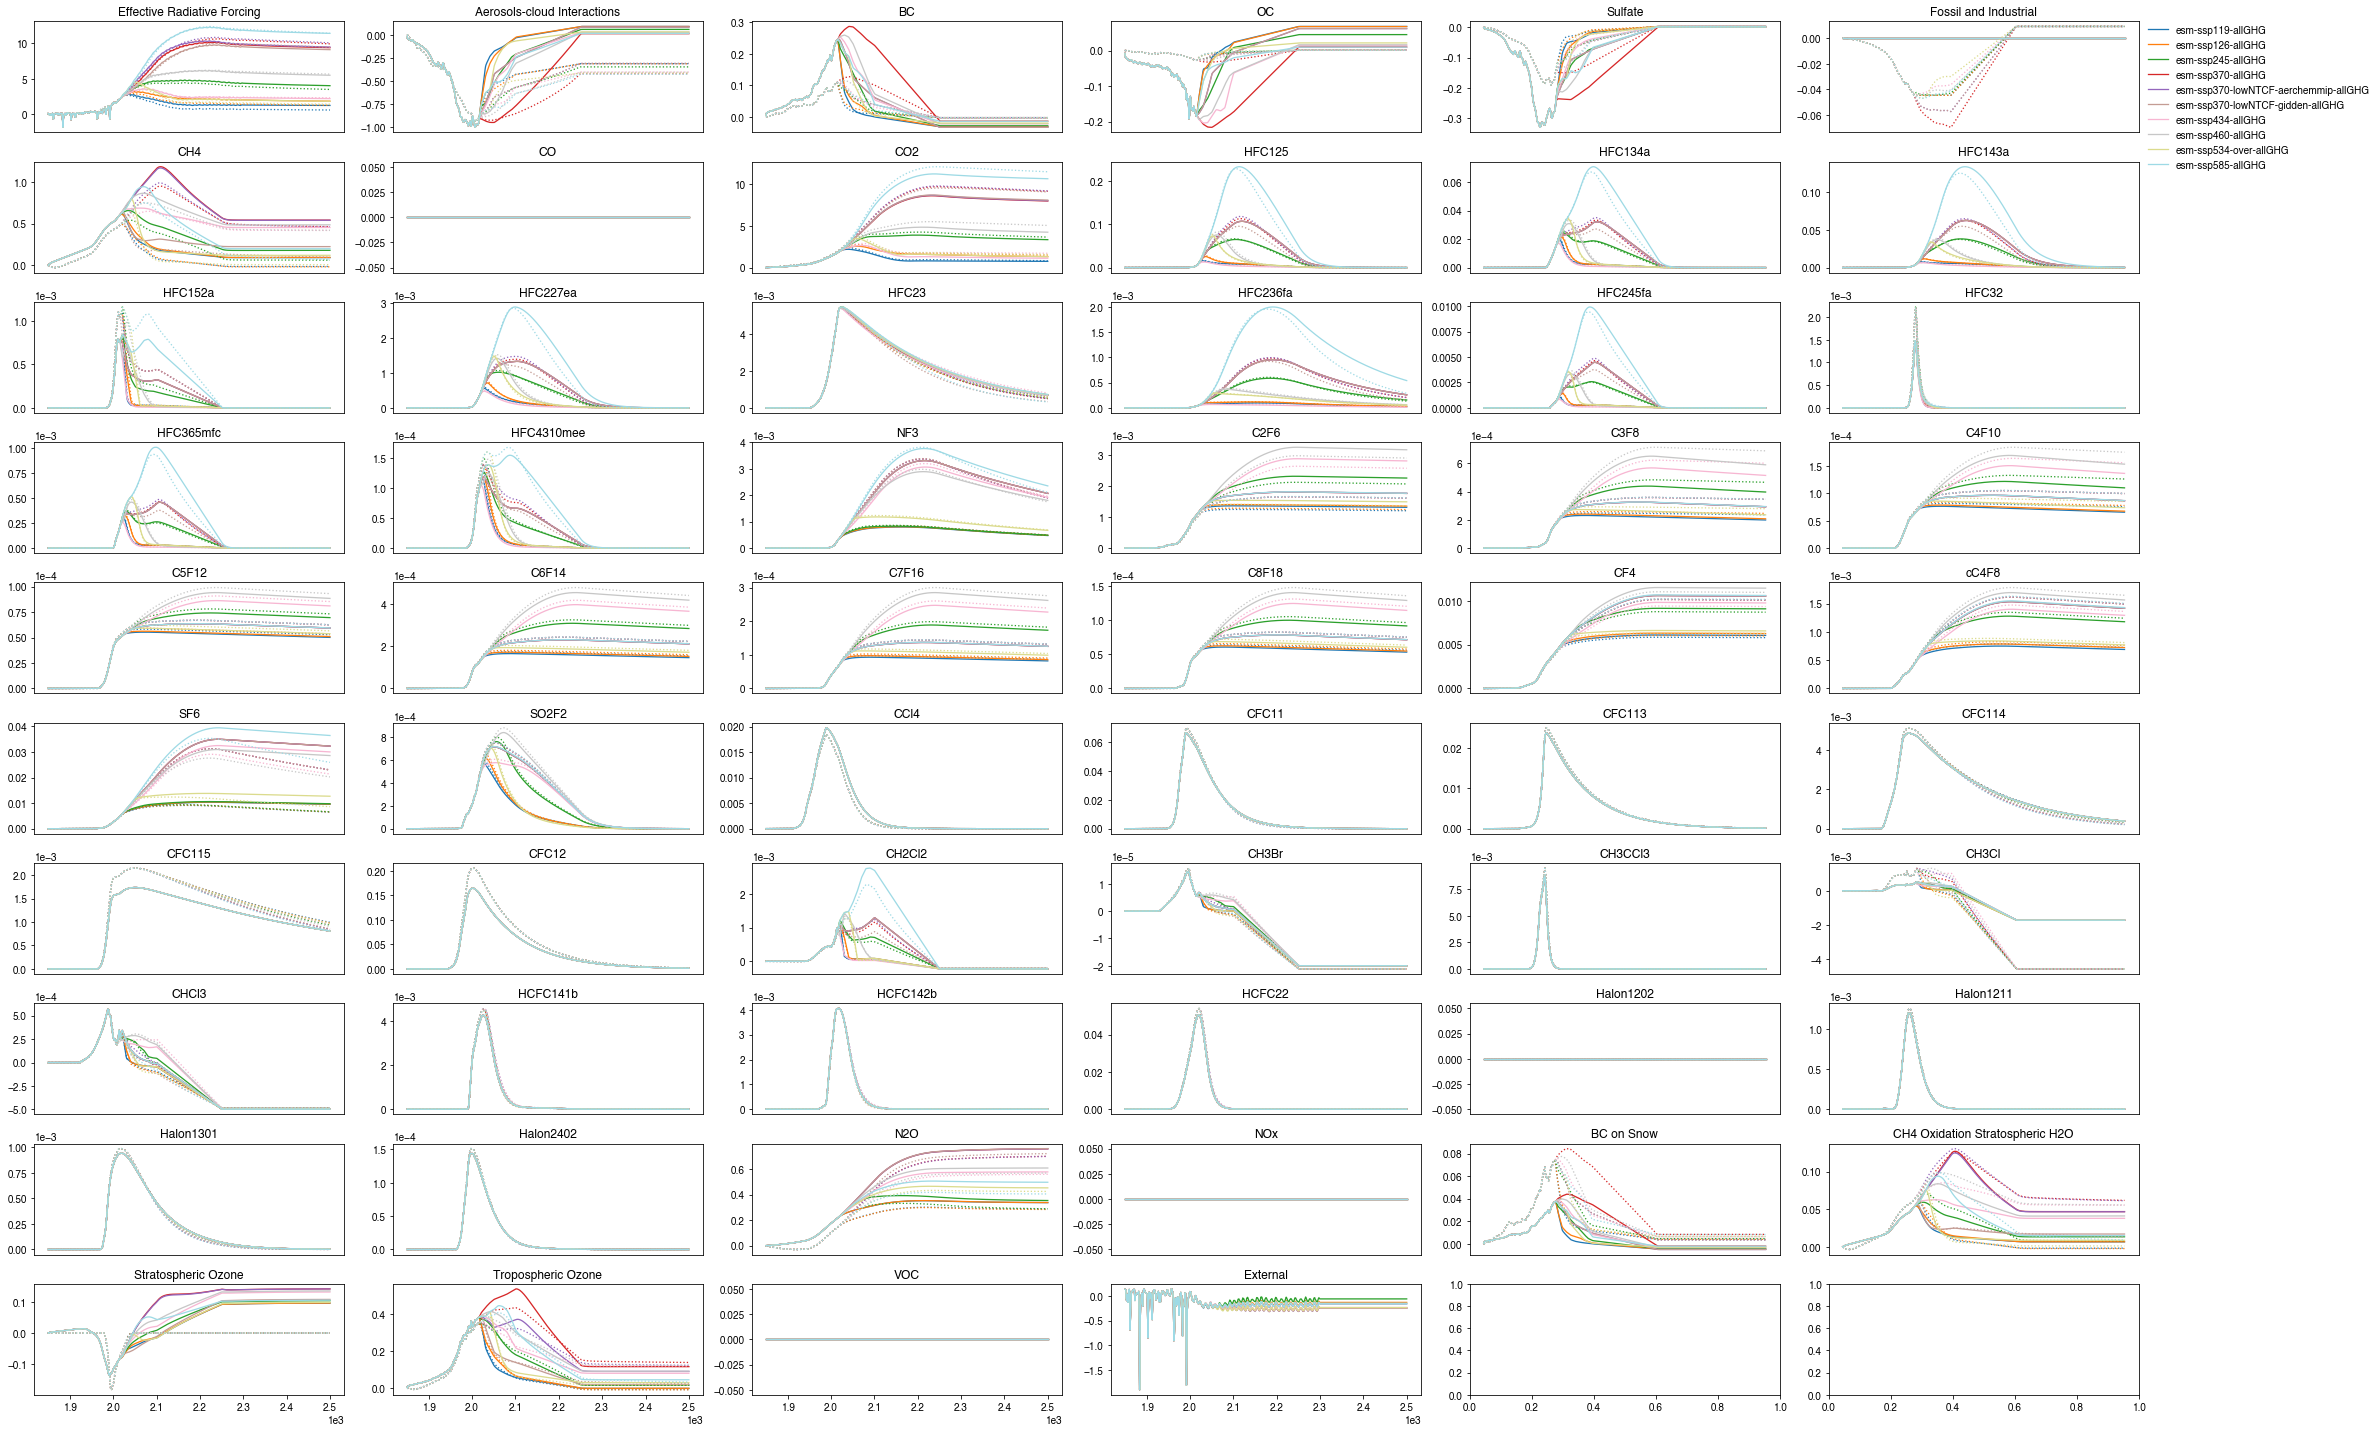

In [14]:
forc_list = all_forc_out.index.levels[2]
scenario_list = all_forc_out.index.levels[1]

colors = dict(zip(scenario_list,matplotlib.cm.tab20(np.linspace(0,1,scenario_list.size))))

fig,ax = plt.subplots(10,6,figsize=(30,20))

for i,a in enumerate(ax.flatten()[:forc_list.size]):
    for scen in scenario_list:
        a.plot(all_forc_out.loc[('World',scen,forc_list[i])].T,color=colors[scen],label=scen,lw=1.3)
        a.set_title(forc_list[i].split('|')[-1])
        if forc_list[i] in magicc_scm.index.levels[-1]:
            a.plot(magicc_scm.loc[('World',scen,forc_list[i])].iloc[3:],':',color=colors[scen],lw=1.3)
            
[a.set_xticks([]) for a in ax[:-1,:].flatten()]
            
plt.tight_layout()
ax[0,5].legend(loc='upper left',bbox_to_anchor=(1,1.05))

# fig.savefig('./GIR_output/RCMIP/RCMIP_allGHG_ERF.pdf',bbox_inches='tight',dpi=600)

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.


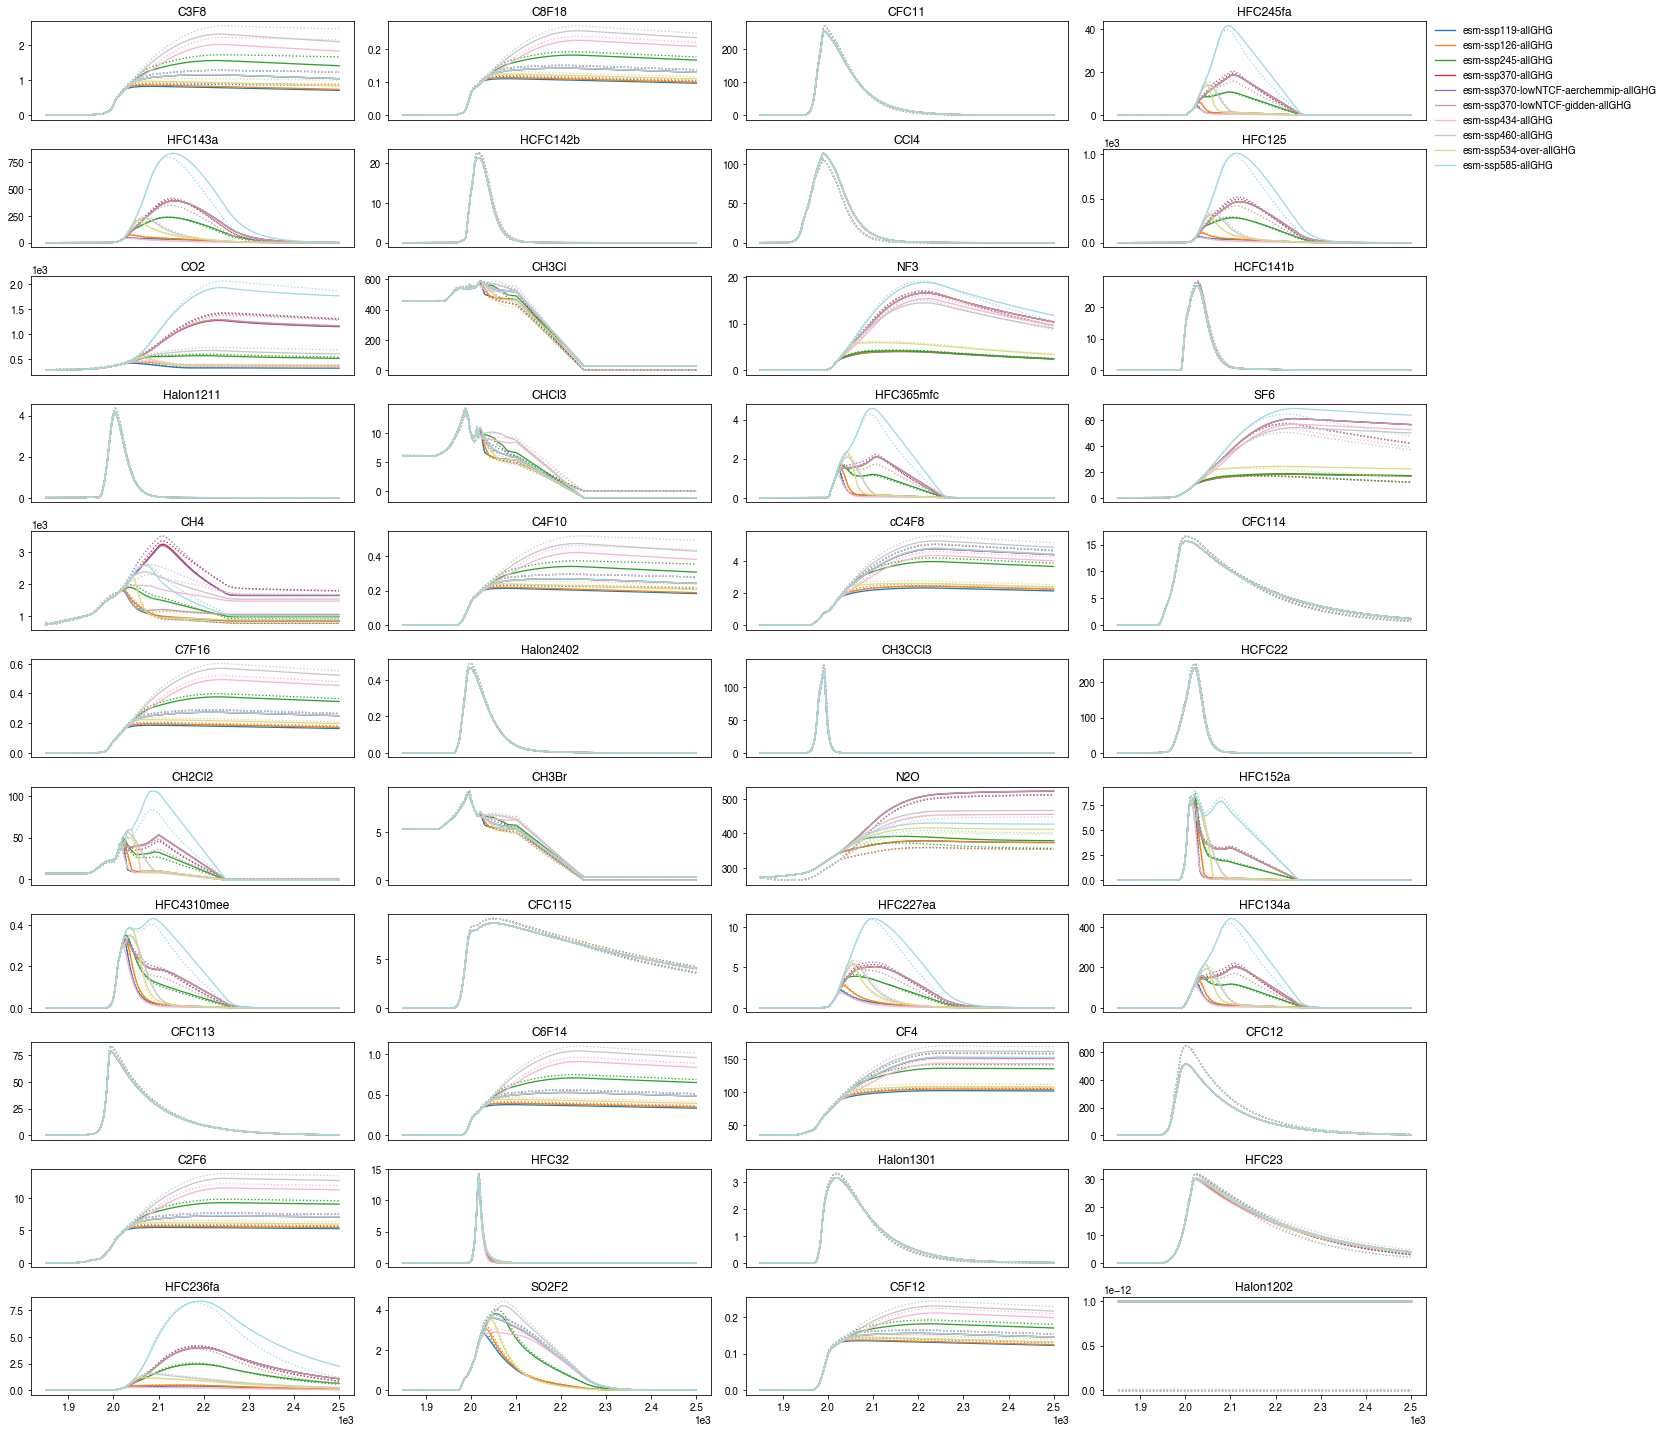

In [15]:
conc_list = list(set(concs_RCMIP_out.index.levels[2][concs_RCMIP_out.index.codes[2]]))
scenario_list = concs_RCMIP_out.index.levels[1]

colors = dict(zip(scenario_list,matplotlib.cm.tab20(np.linspace(0,1,scenario_list.size))))

fig,ax = plt.subplots(11,4,figsize=(20,20))
 
for i,a in enumerate(ax.flatten()):
    for scen in scenario_list:
        a.plot(concs_RCMIP_out.loc[('World',scen,conc_list[i])].T,color=colors[scen],label=scen,lw=1.3)
        a.set_title(conc_list[i].split('|')[-1])
        if conc_list[i] in magicc_scm.index.levels[-1]:
            a.plot(magicc_scm.loc[('World',scen,conc_list[i])].iloc[3:],':',color=colors[scen],lw=1.3)
            
[a.set_xticks([]) for a in ax[:-1,:].flatten()]
plt.tight_layout()
ax[0,3].legend(loc='upper left',bbox_to_anchor=(1,1.05))
fig.savefig('./GIR_output/RCMIP/RCMIP_allGHG_concs.pdf',bbox_inches='tight',dpi=600)

In [16]:
magicc_compare_rf = magicc_scm.loc[('World',scenario_list,GIR_to_RCMIP_map_forc['RCMIP_forc_key']),:].reset_index().set_index(['Scenario','Variable']).T.loc[range(1850,2501)]
GIR_compare_rf = all_forc_out.loc[('World',scenario_list),:].reset_index().set_index(['Scenario','Variable']).T.loc[range(1850,2501)]

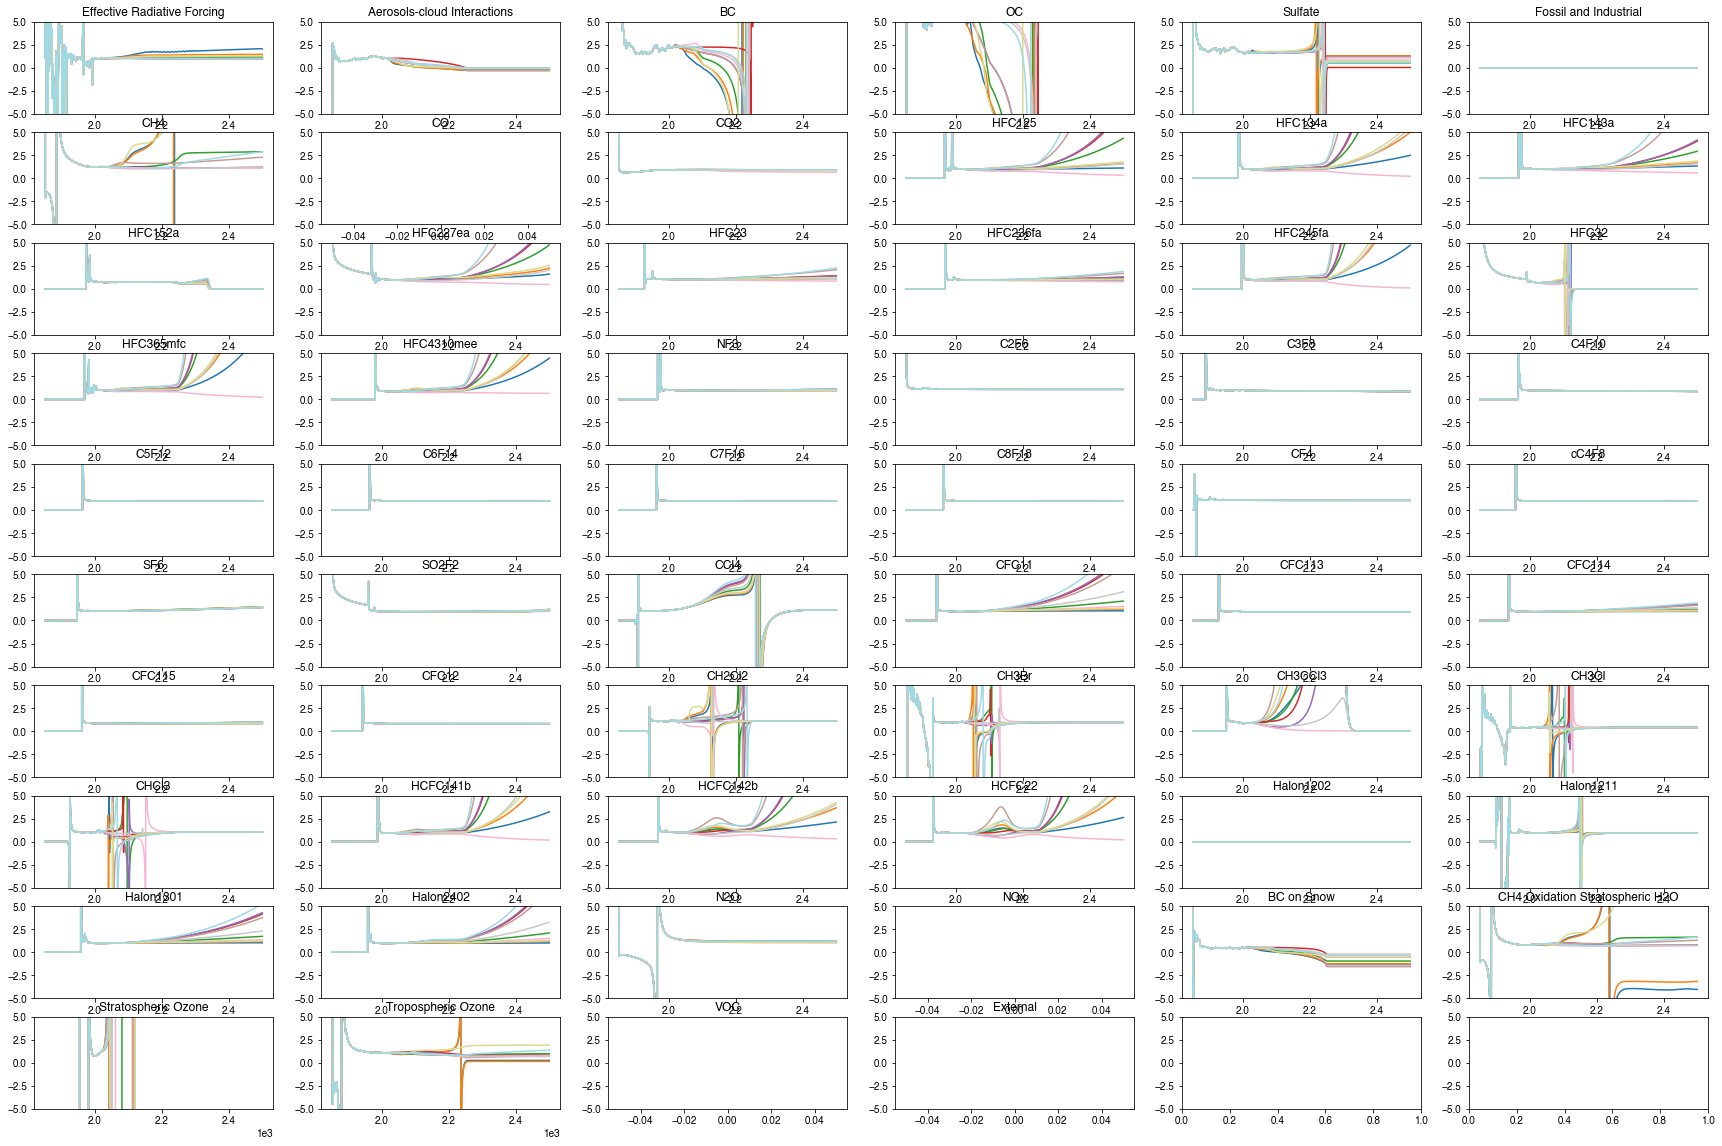

In [17]:
rf_ratio=(GIR_compare_rf / (magicc_compare_rf+1e-30))
fig,ax = plt.subplots(10,6,figsize=(30,20))
[ax.flatten()[i].plot(rf_ratio[(x,y)],color=colors[x]) for x in scenario_list for i,y in enumerate(forc_list)]
[a.set_ylim(-5,5) for a in ax.flatten()]
[ax.flatten()[i].set_title(y.split('|')[-1]) for i,y in enumerate(forc_list)]
print()